In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sb
from statsmodels.tsa.seasonal import STL
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import urllib
#------------------
from dataset import TimeSeriesDataset
from models import MLR, MLP
from resnet_family import resnet20_cifar
from utils_cm import compute_cm

## Generate a synthetic time-series data

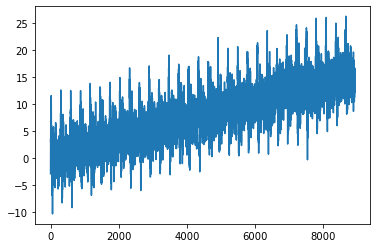

In [121]:
total_days = 31
trend_slope = 15
noise_coef = 2
noise_coef_outlier = 0 * noise_coef

x_period = np.linspace(0, 2*np.pi, 288)
signal = []
for _ in range(total_days):
    y = 10 * np.sin(4 * x_period) * np.exp(-0.5 * x_period)
    y[-100:] = 0
    n = noise_coef * np.random.randn(len(x_period))
    if np.random.choice(7) == 0:
        n += noise_coef_outlier * np.random.randn(len(x_period))
    y += n
    signal.append(y)
signal = np.hstack(signal)

trend = trend_slope * np.linspace(0, 1, len(signal))
signal += trend
x = np.arange(len(signal))

regressor = trend + np.cos(.0005 * x) + 0.1 * np.random.randn(len(trend))

plt.plot(signal)

In [122]:
stl = STL(signal[:-288], period=288, seasonal=7)
stl_result = stl.fit()

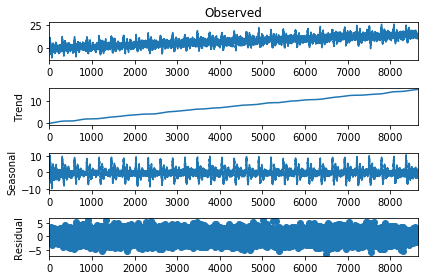

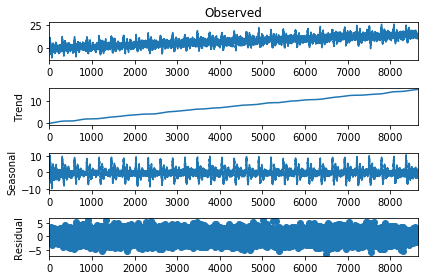

In [123]:
stl_result.plot()

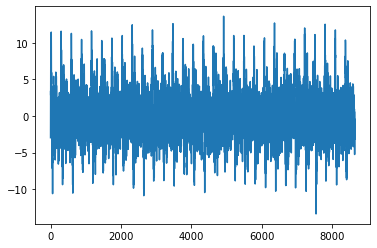

In [124]:
seasonal = stl_result.seasonal
trend = stl_result.trend
signal_train_detrend = signal[:-288] - trend
plt.plot(signal_train_detrend)

In [125]:
train_labels = signal_train_detrend
train_data = np.hstack([seasonal.reshape(-1, 1)])
test_labels = signal[-288:]
test_data = np.hstack([seasonal[-288:].reshape(-1, 1)])

test_trend = ((trend[-1] - trend[-288]) + trend[-288:])

### Add external regressors to the feature set

In [126]:
# train_data = np.hstack([train_data, regressor[:-288].reshape(-1, 1)])
# test_data = np.hstack([test_data, regressor[-288:].reshape(-1, 1)])

In [127]:
train_data.shape, test_data.shape

((8640, 1), (288, 1))

In [128]:
train_loader = DataLoader(TimeSeriesDataset(train_data, train_labels), batch_size=16, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(test_data, test_labels), batch_size=16, shuffle=False)

## [Training Model and Configuration](#Training-Model-and-Configuration)

In [187]:
hidden_layers = [100, 100, 100, 100]
dropout = 0.5
lr=0.001
tau = 1
wd = 0.005 #  0.01**2 * (1 - dropout) / (2. * len(train_loader) * tau)

model = MLR(input_size=train_data.shape[1], nclasses=1, hidden_layers=hidden_layers, dropout=dropout)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
model.net

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): Dropout(p=0.5, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=100, out_features=1, bias=True)
)

In [188]:
loss_vec = []
reset_loss_every = 300
n_epochs = 20
device = "cpu"
model.to(device)
model.train()

for epoch in range(n_epochs):
    for it, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = batch
        output = model(data.float().to(device))
        loss = F.mse_loss(output, target.view(-1, 1).to(device))
        loss_vec.extend([loss.item()])
        loss.backward()
        optimizer.step()
        
        if (it % reset_loss_every) == 0:
            print(f"epoch: {epoch}, it: {it}, average_loss: {np.mean(loss_vec)}")
            loss_vec = []


epoch: 0, it: 0, average_loss: 7.635723114013672
epoch: 0, it: 300, average_loss: 6.2394663679599764
epoch: 1, it: 0, average_loss: 4.773937950034936
epoch: 1, it: 300, average_loss: 5.050661201079686
epoch: 2, it: 0, average_loss: 4.878454800446828
epoch: 2, it: 300, average_loss: 5.206090923547745
epoch: 3, it: 0, average_loss: 4.60075288588802
epoch: 3, it: 300, average_loss: 4.4893274652957915
epoch: 4, it: 0, average_loss: 4.368853503962358
epoch: 4, it: 300, average_loss: 4.350954855879148
epoch: 5, it: 0, average_loss: 4.209218634665012
epoch: 5, it: 300, average_loss: 4.163420680960019
epoch: 6, it: 0, average_loss: 4.367690428346395
epoch: 6, it: 300, average_loss: 3.930159107049306
epoch: 7, it: 0, average_loss: 4.1743231728672985
epoch: 7, it: 300, average_loss: 4.002002807458242
epoch: 8, it: 0, average_loss: 3.6409656564394632
epoch: 8, it: 300, average_loss: 3.91429727991422
epoch: 9, it: 0, average_loss: 3.681478876868884
epoch: 9, it: 300, average_loss: 3.67292255262533

Test mse_loss = 5.362975120544434


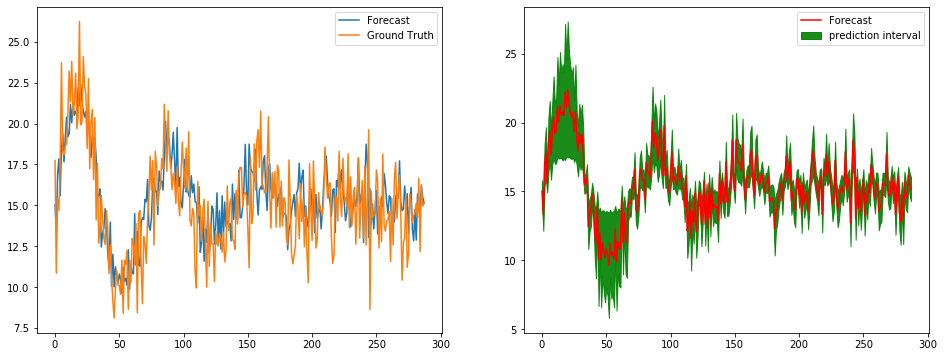

In [189]:
model.to(device)
model.train()

ensemble_size = 1000

loss_vec = []
forecast = []
gt = []
for it, batch in enumerate(test_loader):
    data, target = batch
    output = []
    for ensemble_it in range(ensemble_size):
        output.append(model(data.float().to(device)).data.numpy())
    output = np.hstack(output)
    forecast.append(output)
    gt.append(target.view(-1).data.numpy())
    
forecast = np.vstack(forecast)
forecast += test_trend[:, np.newaxis]
predictive_mean = forecast.mean(1)
predictive_std = forecast.std(1)
gt = np.hstack(gt)
mse_loss = ((gt - predictive_mean)**2).mean()
print(f"Test mse_loss = {mse_loss}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(predictive_mean, label="Forecast")
axes[0].plot(gt, label="Ground Truth")
axes[0].legend()
axes[1].plot(predictive_mean, color='r', label="Forecast")
axes[1].fill_between(np.arange(288), predictive_mean-2*predictive_std, predictive_mean+2*predictive_std, label='prediction interval', color='g', alpha=0.9);
axes[1].legend();

Repeat the above training+evaluation experiment for two different values of DropourRate={0, 0.5} in the [Training-Model-and-Configuration](http://localhost:8888/notebooks/uncertainty_regression.ipynb#Training-Model-and-Configuration) cell (above) and see how that single change introduces the prediction interval.